# Variational Autoencoder

Following on from the [previous post](https://chrisorm.github.io/VI-to-VAE.html) that bridged the gap between VI and VAEs, in this post, I implement a VAE (heavily based on the [Pytorch example script](https://github.com/pytorch/examples/tree/master/vae)!). We lay out the problem we are looking to solve, give some intuition about the model we use, and then evaluate the results.

## Problem

Rather than resorting to MNIST, we will try to learn the distribution of one-hot 4 dimensional vectors. This is simple enough that we are able to use a latent variable of size 2 - and we can therefore visualise the distribution learnt by the model. 

To model this, we will use the following specification:

$p(z) \sim \mathcal{N}(0,I_{2})$

$p(x \mid z) \sim \mathcal{N}(f(z)[0],f(z)[1])$

$q(z \mid x) \sim \mathcal{N}(g(x)[0], g(x)[1])$

where f and g are neural networks, and the $[0]$ and $[1]$ indicate the first and second outputs of the network. For a more complete review, see [this post](https://chrisorm.github.io/VI-to-VAE.html).

We will use the analytic KLD formulation of the ELBO, as proposed in [the original paper](https://arxiv.org/pdf/1312.6114.pdf).

## Intuition

From the above probabilistic formulation, we can offer an intuition behind the roles of the neural networks. Network g can be seen as an encoder - it takes a sample, and transforms this into the parameters of the posterior over z. Network f is a decoder - it takes the latent "representation", z, and turns this into a distribution over x. 

At test time, we can simply take the mode of the two distributions, and in this case, we get an encoder-decoder pair: 

$E(x,z) = argmax_{z} \ q(z \mid x) $

$D(x,z) = argmax_{x} \ p(x \mid z) $

## Code

Now we have laid out the theory, let's look at an example!

In [1]:
import torch
from torch import nn
from torch.autograd import Variable

import numpy as np

In [2]:
representation_size = 2
input_size = 4
n_samples = 2000
batch_size = 5

In [3]:
n_samples_per_batch = n_samples//input_size

y = np.array([i for i in range(input_size)  for _ in range(n_samples_per_batch)])

d = np.identity(input_size)
x = np.array([d[i] for i in y], dtype=np.float32)

Some example data points:

In [21]:
print(x[[10, 58 ,610, 790, 1123, 1258, 1506, 1988]])

[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]


In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.en1 = nn.Linear(input_size, 200)
        self.en_mu = nn.Linear(200, representation_size)
        self.en_std = nn.Linear(200, representation_size)
        self.de1 = nn.Linear(representation_size, 200)
        self.de2 = nn.Linear(200, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        """Encode a batch of samples, and return posterior parameters for each point."""
        h1 = self.relu(self.en1(x))
        return self.en_mu(h1), self.en_std(h1)
    
    def decode(self, z):
        """Decode a batch of latent variables"""
        
        h2 = self.relu(self.de1(z))
        return self.sigmoid(self.de2(h2))
    
    def reparam(self, mu, logvar):
        """Reparameterisation trick to sample z values. 
        This is stochastic during training,  and returns the mode during evaluation."""
        
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
            
    
    def forward(self, x):
        """Takes a batch of samples, encodes them, and then decodes them again to compare."""
        mu, logvar = self.encode(x.view(-1, input_size))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss(self, reconstruction, x, mu, logvar):
        """ELBO assuming entries of x are binary variables, with closed form KLD."""
        
        bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, input_size))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= x.view(-1, input_size).data.shape[0] * input_size

        return bce + KLD
    
    def get_z(self, x):
        """Encode a batch of data points, x, into their z representations."""
        
        mu, logvar = self.encode(x.view(-1, input_size))
        return self.reparam(mu, logvar)


In [6]:
model = VAE()

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
def train(epoch, batches_per_epoch = 501, log_interval=500):
    model.train()
    
    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss(recon_batch, data, mu, logvar)
        loss.backward()
        #train_loss += loss.data[0]
        optimizer.step()
        if (i % log_interval == 0) and (epoch % 5 ==0):
            #Print progress
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, i * batch_size, batch_size*batches_per_epoch,
                loss.data[0] / len(data)))

    print('====> Epoch: {} done!'.format(
          epoch))


def test(epoch, batches_per_epoch=1):
    model.eval()

    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        recon_batch, mu, logvar = model(data)
        if i == 0:
            n = min(data.size(0), 2)
            print(data.view(batch_size, 2,2)[:n])
            print(recon_batch.view(batch_size, 2,2)[:n])

In [9]:
print_examples = False #Change to true if you want to see some examples at each step!
for epoch in range(1, 30):
    train(epoch)
    if print_examples:
        test(epoch)

====> Epoch: 1 done!
====> Epoch: 2 done!
====> Epoch: 3 done!
====> Epoch: 4 done!
Train Epoch: 5 [0/2505]	Loss: 0.084151
Train Epoch: 5 [2500/2505]	Loss: 0.080040
====> Epoch: 5 done!
====> Epoch: 6 done!
====> Epoch: 7 done!
====> Epoch: 8 done!
====> Epoch: 9 done!
Train Epoch: 10 [0/2505]	Loss: 0.089166
Train Epoch: 10 [2500/2505]	Loss: 0.067121
====> Epoch: 10 done!
====> Epoch: 11 done!
====> Epoch: 12 done!
====> Epoch: 13 done!
====> Epoch: 14 done!
Train Epoch: 15 [0/2505]	Loss: 0.082387
Train Epoch: 15 [2500/2505]	Loss: 0.070755
====> Epoch: 15 done!
====> Epoch: 16 done!
====> Epoch: 17 done!
====> Epoch: 18 done!
====> Epoch: 19 done!
Train Epoch: 20 [0/2505]	Loss: 0.067315
Train Epoch: 20 [2500/2505]	Loss: 0.086615
====> Epoch: 20 done!
====> Epoch: 21 done!
====> Epoch: 22 done!
====> Epoch: 23 done!
====> Epoch: 24 done!
Train Epoch: 25 [0/2505]	Loss: 0.125867
Train Epoch: 25 [2500/2505]	Loss: 0.070417
====> Epoch: 25 done!
====> Epoch: 26 done!
====> Epoch: 27 done!
==

In [10]:
data = Variable(torch.from_numpy(x), requires_grad=False)
model.train()
zs = model.get_z(data).data.numpy()

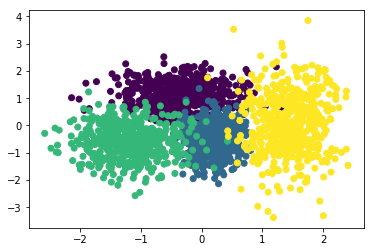

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(zs[:,0], zs[:, 1], c=y)

The above plot generates stochastic z values. As we can see, their is some overlap between the different classes. However, the VAE has learnt roughly distinct regions in the Z space to correspond to each class in our data. This is a great result, because we never used the labels in the learning process, and yet have learnt simple representations for our data, and these representations encode sufficient information to cluster data points!

If we take the mode rather than samples from the encoder, we can see how the modes of the distributions look.

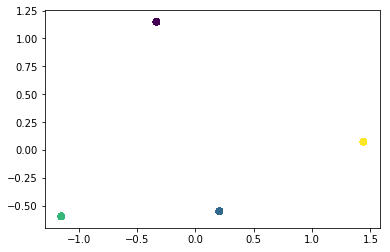

In [12]:
data = Variable(torch.from_numpy(x), requires_grad=False)
model.eval()
zs = model.get_z(data).data.numpy()

plt.scatter(zs[:,0], zs[:, 1], c=y)

As this shows, it has learnt that their should be 4 means for the posterior, and positioned them far away from each other.

## What went wrong?

Whilst this result is good, there are some troubling aspects - that the clustering overlaps is the most obvious one. If we pick a point that overlaps on the above plot, such as [0.5, 0.6], and decode it, we will see what this looks like.


In [18]:
test_point = np.array([0.5, 0.6], dtype=np.float32).reshape(1,-1)
test_point = Variable(torch.from_numpy(test_point), requires_grad=False)
s = model.decode(test_point)
s.data


 0.2693  0.4425  0.0012  0.2021
[torch.FloatTensor of size 1x4]

This is not really a clear example - whilst we expect to have to do some rounding to get a 1 hot vector, this is an interpolation between 3 different classes. Whilst this may be desirable behaviour, it would be nice if there was less overlap.

As an example, a good point reconstructs to:

In [16]:
test_point = np.array([0., 0.], dtype=np.float32).reshape(1,-1)
test_point = Variable(torch.from_numpy(test_point), requires_grad=False)
s = model.decode(test_point)
s.data


 0.0593  0.8851  0.0553  0.0031
[torch.FloatTensor of size 1x4]

Another problem is the size of the space in z given to each class. If we look at the first visualisation, the blue class has a much smaller amount of space than say the yellow class. This means if we sample from z, which is a uniform gaussian, we will not draw uniformly from each class - we will oversample the yellow class and undersample the blue, for example.

## What could we do to improve matters?

One big problem, is that we are still imposing some structure on the problem. Each posterior is a gaussian by definition - the neural network means we have a very complex hierarchical model to represent the posterior, but the final form is still a gaussian for each sample. 

What we would like is to have a network which can be arbitrarily flexible - even in the final form. However, this is complex as we have the sampling operation to incorporate. 

There is lots of places where this happens - GANs is one example. These are often termed implicit generative models - one where the form of each part is learned by the network, not just the parameters of an explicit distribution. 

A [previous post](https://chrisorm.github.io/GM-Disc-as-ratios.html) covers some necessary theory for us to extend what we have done here, and this will be the topic of the next post.

# Summary

In this post, we have introduced the VAE in practice, covered some properties of it, and identified a few problems. In the next post we will move onto some recent work, covering extensions to this approach to help correct some of these issues.